In [1]:
# Import packages
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from firedrake.meshadapt import *
import ufl
import numpy as np
from firedrake import UnitSquareMesh,FunctionSpace,VectorFunctionSpace,SpatialCoordinate,pi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test for a simple Equation
First, start from simple case: 

$
-\nabla^2 u + u  = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma,
$

with:

$
f(x, y) = (1.0 + 8.0\pi^2)\cos(2\pi x)\cos(2\pi y).
$

This conveniently yields the analytical solution:

$
u(x, y) = \cos(2\pi x)\cos(2\pi y).
$

In [31]:
# Define class for L2 projector
class L2Projector:
    def __init__(self, mesh, P1_vec, phi_old,**kwargs):
        self.mesh = mesh
        self.P1_vec = P1_vec
        self.phi_old = phi_old
        self.dim = mesh.geometric_dimension()
        self._grad_phi = Function(P1_vec)

        # Measures
        degree = kwargs.get('quadrature_degree')
        self.dx = dx(domain=mesh, degree=degree)
        self.ds = ds(domain=mesh, degree=degree)
        self.dS = dS(domain=mesh, degree=degree)
        self.fix_boundary_nodes = kwargs.pop('fix_boundary_nodes', False)

    # Include the l2_projector code you provided
    @property
    def l2_projector(self):
        if hasattr(self, '_l2_projector'):
            return self._l2_projector
        u_cts = TrialFunction(self.P1_vec)
        v_cts = TestFunction(self.P1_vec)
        n = FacetNormal(mesh)

        # Domain interior
        phi_grad_v_dx = self.phi_old*dot(v_cts, n)*ds-ufl.inner(self.phi_old, ufl.div(v_cts))*self.dx
        a = ufl.inner(v_cts, u_cts)*self.dx
        L = phi_grad_v_dx

        # Enforce no movement normal to boundary
        n = ufl.FacetNormal(self.mesh)
        bcs = []
        for i in self.mesh.exterior_facets.unique_markers:
            if self.fix_boundary_nodes:
                bcs.append(DirichletBC(self.P1_vec, 0, i))
                continue

            # Check for axis-aligned boundaries
            _n = [assemble(abs(n[j])*self.ds(i)) for j in range(self.dim)]
            if np.allclose(_n, 0.0):
                raise ValueError(f"Invalid normal vector {_n}")
            else:
                if np.isclose(_n[0], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(1), 0, i))
                    continue
                elif np.isclose(_n[1], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(0), 0, i))
                    continue

            a_bc = ufl.dot(v_cts, n)*ufl.dot(u_cts, n)*self.ds
            bcs.append(EquationBC(a_bc == 0, self._grad_phi, i))

            s = ufl.perp(n)
            a_bc = ufl.dot(v_cts, s)*ufl.dot(u_cts, s)*self.ds
            L_bc = ufl.dot(v_cts, s)*phi_grad_v_dx
            bcs.append(EquationBC(a_bc == L_bc, self._grad_phi, i))

        # Create solver
        problem = LinearVariationalProblem(a, L, self._grad_phi, bcs=None)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._l2_projector = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._l2_projector


In [32]:
u_grad_diffs = []
u_grad_exacts = []
u_grad_l2s = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 1)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)
    u_grad_exacts.append(u_grad_exact)
    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()
    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    u_grad_l2s.append(u_grad_l2)
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print(f"The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs.append(u_grad_diff)

The global error is 0.80062785 for 10x10 Mesh
The global error is 0.22879336 for 20x20 Mesh
The global error is 0.10791515 for 30x30 Mesh
The global error is 0.06348304 for 40x40 Mesh
The global error is 0.04222385 for 50x50 Mesh
The global error is 0.03035615 for 60x60 Mesh
The global error is 0.02302461 for 70x70 Mesh
The global error is 0.01815872 for 80x80 Mesh
The global error is 0.01475210 for 90x90 Mesh
The global error is 0.01226656 for 100x100 Mesh


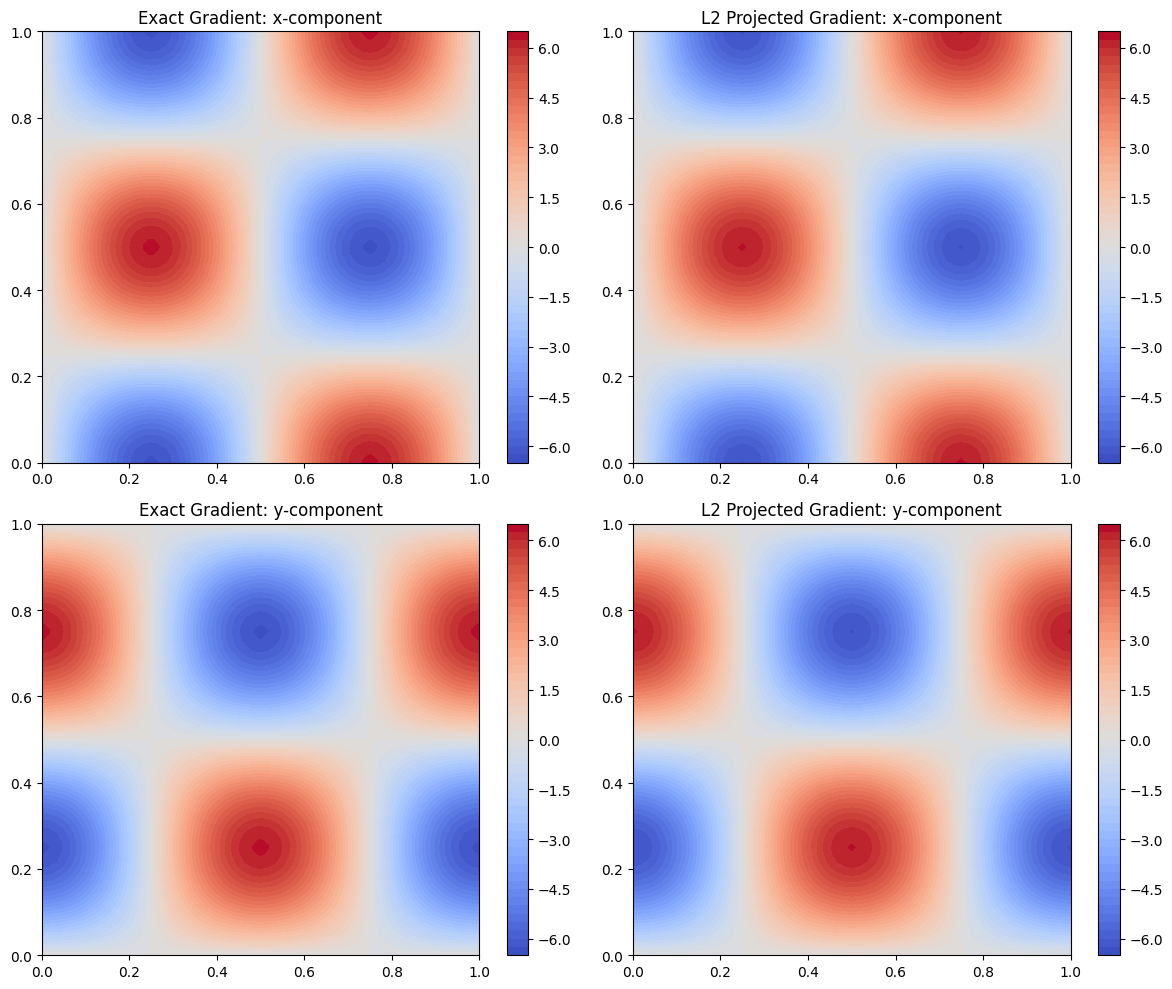

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the x-component of the exact gradient
axes[0,0].set_title("Exact Gradient: x-component")
contour = tricontourf(u_grad_exacts[5].sub(0), axes=axes[0,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])

# Plot the x-component of the L2 projected gradient
axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2s[5].sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])

# Plot the x-component of the exact gradient
axes[1,0].set_title("Exact Gradient: y-component")
contour = tricontourf(u_grad_exacts[5].sub(1), axes=axes[1,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])

# Plot the x-component of the L2 projected gradient
axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2s[5].sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

Try with CG2

In [35]:
u_grad_diffs_cg2 = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 2)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 2)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs_cg2.append(u_grad_diff)

The global error is 0.11468764 for 10x10 Mesh
The global error is 0.03380758 for 20x20 Mesh
The global error is 0.01563092 for 30x30 Mesh
The global error is 0.00892670 for 40x40 Mesh
The global error is 0.00575568 for 50x50 Mesh
The global error is 0.00401387 for 60x60 Mesh
The global error is 0.00295674 for 70x70 Mesh
The global error is 0.00226775 for 80x80 Mesh
The global error is 0.00179404 for 90x90 Mesh
The global error is 0.00145450 for 100x100 Mesh


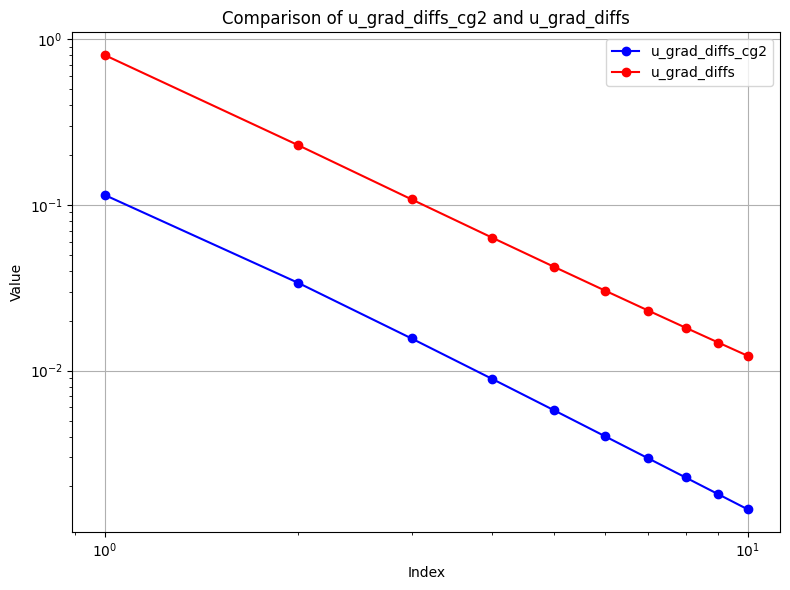

In [37]:
# Plotting
# Assuming linear spacing for nodes/elements
elements = np.linspace(1, 10, 10)
plt.figure(figsize=(8, 6))

plt.plot(elements, u_grad_diffs_cg2, '-o', label="u_grad_diffs_cg2", color="blue")
plt.plot(elements, u_grad_diffs, '-o', label="u_grad_diffs", color="red")

# Adding title and labels
plt.title("Comparison of u_grad_diffs_cg2 and u_grad_diffs")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.yscale("log")  # if you want a logarithmic scale for residuals
plt.xscale("log")
# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
u_grad_exacts = []
u_grad_l2s = []

for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 1)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact_ = Function(P1).interpolate(x*(1-x)*y*(1-y)*exp(x+y)*sin(2*pi*x*y))
    # Calculate analytical gradient of u
    u_grad_exact_expr_ = as_vector([(y-1)*y*exp(x+y)*((x**2+x-1)*sin(2*pi*x*y)+2*pi*(x-1)*x*y*cos(2*pi*x*y)),
                                    (x-1)*x*exp(x+y)*((y**2+y-1)*sin(2*pi*x*y)+2*pi*(y-1)*x*y*cos(2*pi*x*y))])
    u_grad_exact = project(u_grad_exact_expr_, P1_vec)
    u_grad_exacts.append(u_grad_exact)
    
    laplacian_u_exact = -(
        x*(x - 1)*(
            -4*pi**2*x**2*y*(y - 1)*sin(2*pi*x*y) 
            + 4*pi*x*y*(y - 1)*cos(2*pi*x*y) 
            + 4*pi*x*y*cos(2*pi*x*y) 
            + 4*pi*x*(y - 1)*cos(2*pi*x*y) 
            + y*(y - 1)*sin(2*pi*x*y) 
            + 2*y*sin(2*pi*x*y) 
            + 2*(y - 1)*sin(2*pi*x*y) 
            + 2*sin(2*pi*x*y)
        )*exp(x + y) 
        + y*(y - 1)*(
            -4*pi**2*x*y**2*(x - 1)*sin(2*pi*x*y) 
            + 4*pi*x*y*(x - 1)*cos(2*pi*x*y) 
            + 4*pi*x*y*cos(2*pi*x*y) 
            + x*(x - 1)*sin(2*pi*x*y) 
            + 2*x*sin(2*pi*x*y) 
            + 4*pi*y*(x - 1)*cos(2*pi*x*y) 
            + 2*(x - 1)*sin(2*pi*x*y) 
            + 2*sin(2*pi*x*y)
        )*exp(x + y)
    )

    # Interpolating the Laplacian to the function space (assuming you've defined P1 before):
    f= Function(P1).interpolate(laplacian_u_exact)
    bc = DirichletBC(P1, Constant(0.0), "on_boundary")

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol, bcs =bc)

    # Use the solution of the Poisson equation as phi_old
    projector = L2Projector(mesh, P1_vec, u_sol) #TODO: replace u_exact with u_sol? Boundary?

    # Call L2 projector and get result
    l2_projector = projector.l2_projector
    l2_projector.solve()

    # Compare L2 projected gradient with analytical gradient
    u_grad_l2 = projector._grad_phi

    
    u_grad_l2s.append(u_grad_l2)
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_l2)
    print("The global error is %.4f" % (u_grad_diff))

The global error is 0.0552
The global error is 0.0160
The global error is 0.0078
The global error is 0.0047
The global error is 0.0032
The global error is 0.0023
The global error is 0.0018
The global error is 0.0014
The global error is 0.0012
The global error is 0.0010


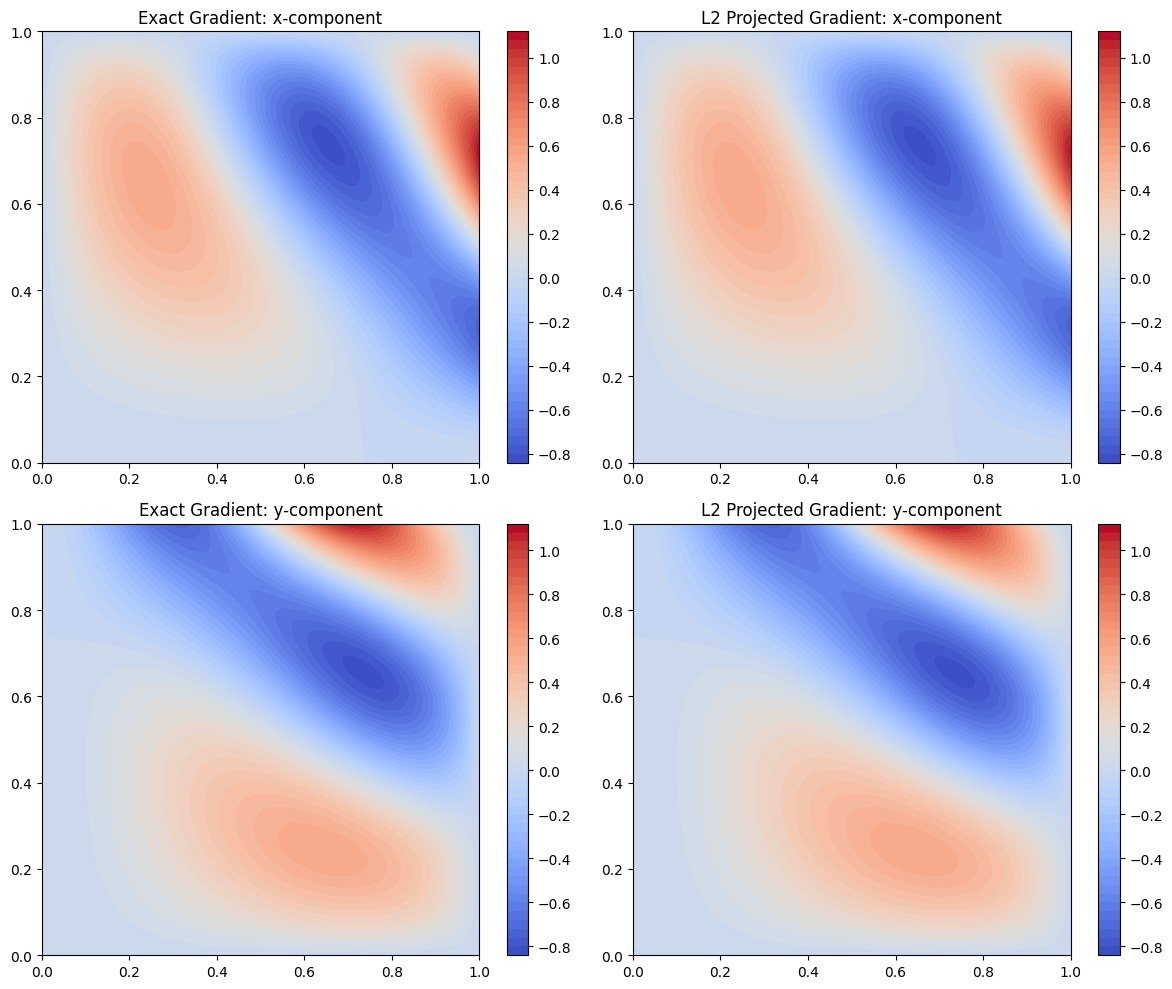

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the x-component of the exact gradient
axes[0,0].set_title("Exact Gradient: x-component")
contour = tricontourf(u_grad_exacts[9].sub(0), axes=axes[0,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])

# Plot the x-component of the L2 projected gradient
axes[0,1].set_title("L2 Projected Gradient: x-component")
contour = tricontourf(u_grad_l2s[9].sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])

# Plot the x-component of the exact gradient
axes[1,0].set_title("Exact Gradient: y-component")
contour = tricontourf(u_grad_exacts[9].sub(1), axes=axes[1,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])

# Plot the x-component of the L2 projected gradient
axes[1,1].set_title("L2 Projected Gradient: y-component")
contour = tricontourf(u_grad_l2s[9].sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

L2 projection seems to be a powerful tool!

In [ ]:
# Create a mesh and define function spaces
mesh = UnitSquareMesh(100, 100)

# Compute the analytical gradient
u_exact = Function(P1).interpolate(sin(pi*x)*sin(pi*y) + pow(x-0.5, 2./3.)*pow(y-0.5, 2./3.))


In [ ]:
# Calculate analytical gradient of u
u_grad_exact_expr = as_vector([(2/3)*pow(y - 0.5, 2./3.)*pow(x-0.5, -1./3.) + pi*sin(pi*y)*cos(pi*x),
                                 (2/3)*pow(x - 0.5, 2./3.)*pow(y-0.5, -1./3.) + pi*sin(pi*x)*cos(pi*y)])
u_grad_exact = project(u_grad_exact_expr, P1_vec)

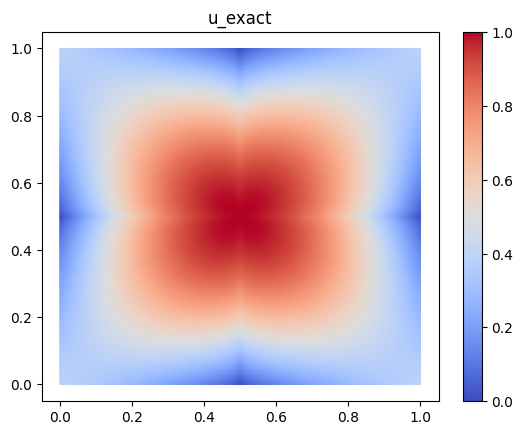

In [ ]:
fig, axes = plt.subplots()
u_plt = tripcolor(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_exact")
plt.show()

In [ ]:
# Use the solution of the Poisson equation as phi_old
projector = L2Projector(mesh, P1_vec, u_exact) #TODO: replace u_exact with u_sol? Boundary?

# Call L2 projector and get result
l2_projector = projector.l2_projector
l2_projector.solve()

# Compare L2 projected gradient with analytical gradient
u_grad_l2 = projector._grad_phi


TypeError: '<' not supported between instances of 'MeshGeometry' and 'MeshGeometry'

When singular happens, crashed.